In [1]:
import pandas as pd
import numpy as np
import math
import re
import matplotlib.pyplot as plt
import seaborn as sns
!pip install waterfallcharts
import waterfall_chart


## Importando a base de dados + Análise exploratória

In [2]:
base=pd.read_csv("base_case.csv")
base.head()

,Canal,SubCanal,Grupo 1,Grupo 2,Afiliação,VL Receita Total,Receita Net MDR,Receita de antecipação de recebiveis,Outras Receitas,Custo de Net MDR,Custo de antecipação de recebiveis,Custo de Outras Receitas
0,DIGITAL,SubCanal 1,Grupo B,LIDER FARMER,00254A8E-59B4-40A5-99AC-CA06A1B37663,227,0,0,227,0,0,113
1,DIGITAL,SubCanal 1,Grupo C,JULIO,005e8e74-2412-48d3-b366-fbb8cc3b4e67,206,0,0,206,0,0,103
2,DIGITAL,SubCanal 1,Grupo B,BASE,005F3E61-7757-46F4-A55F-4E2ED5B52835,51,0,0,51,0,0,26
3,DIGITAL,SubCanal 1,Grupo D,INSIDE,006073e9-052c-44e0-aaa9-3f160fb12bb4,206,0,0,206,0,0,103
4,DIGITAL,SubCanal 1,Grupo B,BASE,00F62BB5-45B2-4C41-921B-4E2650FDDBD4,257,0,0,257,0,0,129


In [3]:
#Descrevendo os valores numéricos dos campos
base.describe().applymap('{:.1f}'.format)

,VL Receita Total,Receita Net MDR,Receita de antecipação de recebiveis,Outras Receitas,Custo de Net MDR,Custo de antecipação de recebiveis,Custo de Outras Receitas
count,10109.0,10109.0,10109.0,10109.0,10109.0,10109.0,10109.0
mean,2114.1,809.3,741.9,557.5,566.5,259.7,278.8
std,52457.3,39112.5,24910.8,11822.1,27378.8,8718.8,5911.1
min,-7391.0,-7391.0,0.0,-16970.0,-5174.0,0.0,-8485.0
25%,22.0,0.0,0.0,1.0,0.0,0.0,0.0
50%,111.0,17.0,0.0,18.0,12.0,0.0,9.0
75%,450.0,123.0,0.0,147.0,86.0,0.0,74.0
max,3911755.0,3911755.0,2436375.0,899917.0,2738229.0,852731.0,449959.0


Aqui a gente já consegue avaliar valores negativos no mínimo de receita e custos. Isso não faz muito sentido e vamos avaliar o erro na base e retirá-los na etapa de tratamento

In [4]:
#Quantos elementos únicos existem em cada um dos campos? 
pd.DataFrame(base.nunique()).rename(columns={0:"cont elementos únicos"})

,cont elementos únicos
Canal,1
SubCanal,3
Grupo 1,5
Grupo 2,43
Afiliação,10109
VL Receita Total,2247
Receita Net MDR,1324
Receita de antecipação de recebiveis,1131
Outras Receitas,1314
Custo de Net MDR,1130


In [5]:
#Avaliando se há valores nulos para serem retirados da base
base.isnull().sum()

Canal                                   0
SubCanal                                0
Grupo 1                                 0
Grupo 2                                 0
Afiliação                               0
VL Receita Total                        0
Receita Net MDR                         0
Receita de antecipação de recebiveis    0
Outras Receitas                         0
Custo de Net MDR                        0
Custo de antecipação de recebiveis      0
Custo de Outras Receitas                0
dtype: int64

VL Receita Total                           AxesSubplot(0.125,0.125;0.0945122x0.755)
Receita Net MDR                         AxesSubplot(0.238415,0.125;0.0945122x0.755)
Receita de antecipação de recebiveis    AxesSubplot(0.351829,0.125;0.0945122x0.755)
Outras Receitas                         AxesSubplot(0.465244,0.125;0.0945122x0.755)
Custo de Net MDR                        AxesSubplot(0.578659,0.125;0.0945122x0.755)
Custo de antecipação de recebiveis      AxesSubplot(0.692073,0.125;0.0945122x0.755)
Custo de Outras Receitas                AxesSubplot(0.805488,0.125;0.0945122x0.755)
dtype: object

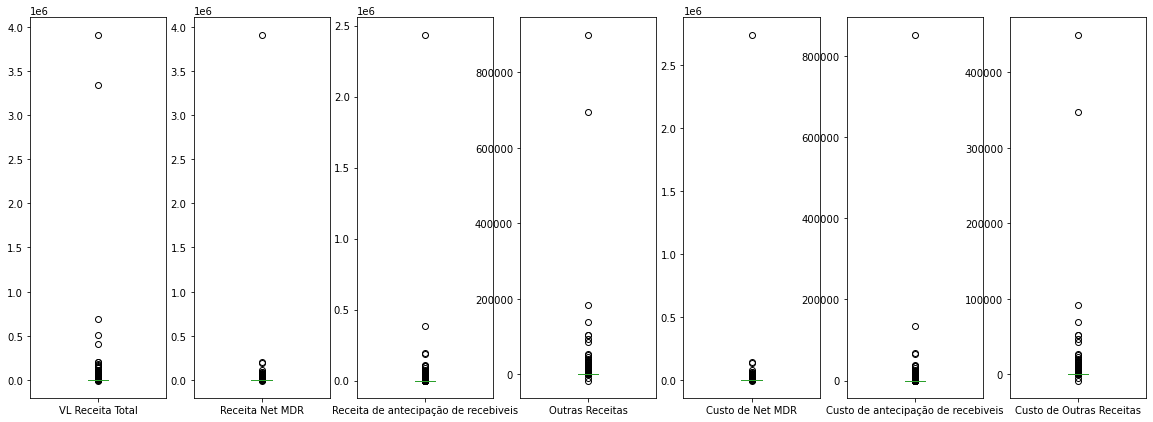

In [6]:
#Entendendo a distribuição dos valores numéricos
base.plot(kind='box',figsize=(20,7),subplots=True)

<AxesSubplot:ylabel='Frequency'>

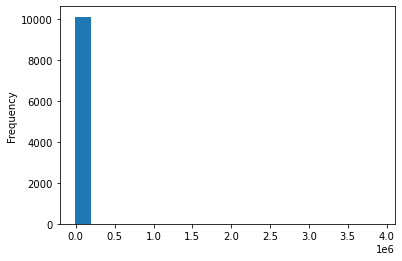

In [7]:
#Vendo em histograma a receita
base["VL Receita Total"].plot.hist(bins=20)

## Tratamento dos dados 
#### 1 - Criação do campo "CUSTO TOTAL"
#### 2 - Compreenção e Remoção dos valores negativos de receita e custos
#### 3 - Compreenção e Remoção dos Outliers

##### 1.1 Criando o custo totaL

In [8]:
#criação do custo total
base["custo_total"]=base["Custo de Net MDR"]+base["Custo de antecipação de recebiveis"]+base["Custo de Outras Receitas"]



##### 1.2 Avaliando os valores negativos e seus impactos na base

In [9]:
# Assumimos a premissa que receita negativa não existe e custo negativo TAMBÉM não existe.
# Sendo assim vamos criar uma coluna que indica se algum campo de receita é negativo. O mesmo faremos para os custos.

base["check_receitas"]=(base["Receita Net MDR"]<0)|(base["Outras Receitas"]<0)|(base["Receita de antecipação de recebiveis"]<0)|(base["VL Receita Total"]<0)
base["check_custos"]=(base["Custo de Net MDR"]<0)|(base["Custo de antecipação de recebiveis"]<0)|(base["Custo de Outras Receitas"]<0)
base

,Canal,SubCanal,Grupo 1,Grupo 2,Afiliação,VL Receita Total,Receita Net MDR,Receita de antecipação de recebiveis,Outras Receitas,Custo de Net MDR,Custo de antecipação de recebiveis,Custo de Outras Receitas,custo_total,check_receitas,check_custos
0,DIGITAL,SubCanal 1,Grupo B,LIDER FARMER,00254A8E-59B4-40A5-99AC-CA06A1B37663,227,0,0,227,0,0,113,113,False,False
1,DIGITAL,SubCanal 1,Grupo C,JULIO,005e8e74-2412-48d3-b366-fbb8cc3b4e67,206,0,0,206,0,0,103,103,False,False
2,DIGITAL,SubCanal 1,Grupo B,BASE,005F3E61-7757-46F4-A55F-4E2ED5B52835,51,0,0,51,0,0,26,26,False,False
3,DIGITAL,SubCanal 1,Grupo D,INSIDE,006073e9-052c-44e0-aaa9-3f160fb12bb4,206,0,0,206,0,0,103,103,False,False
4,DIGITAL,SubCanal 1,Grupo B,BASE,00F62BB5-45B2-4C41-921B-4E2650FDDBD4,257,0,0,257,0,0,129,129,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10104,DIGITAL,SubCanal 3,Grupo B,FARMER A,819976950,8366,3559,4807,0,2491,1683,0,4174,False,False
10105,DIGITAL,SubCanal 3,Grupo B,FARMER A,986922471,3911755,3911755,0,0,2738229,0,0,2738229,False,False
10106,DIGITAL,SubCanal 3,Grupo B,FARMER A,BA621BEF-1EDD-47A5-80B8-D60511A071B4,102712,0,0,102712,0,0,51356,51356,False,False
10107,DIGITAL,SubCanal 3,Grupo B,FARMER A,D96D6776-7AC8-4B34-A9ED-71F2A76CEBE4,693769,0,0,693769,0,0,346885,346885,False,False


In [10]:
a=base.shape
b=base[base["check_custos"]==True].shape
c=base[base["check_receitas"]==True].shape
d=base[(base["check_custos"]==True)|(base["check_receitas"]==True)].shape
print("assumindo valores negativos como erro:")
print("os tamanhos da base total, base com erros de receita, base com erro no custo e base com erro nos dois campos são respectivamente")
print(a,b,c,d)
e=round(d[0]/a[0]*100,1)
print("ou seja, {}% das linhas tem erro e onde há ERRO na receita, tem erro no custo!".format(e))

assumindo valores negativos como erro:
os tamanhos da base total, base com erros de receita, base com erro no custo e base com erro nos dois campos são respectivamente
(10109, 15) (301, 15) (315, 15) (315, 15)
ou seja, 3.1% das linhas tem erro e onde há ERRO na receita, tem erro no custo!


In [11]:
#vamos estudar quem são nossos ofensores
base.describe()

,VL Receita Total,Receita Net MDR,Receita de antecipação de recebiveis,Outras Receitas,Custo de Net MDR,Custo de antecipação de recebiveis,Custo de Outras Receitas,custo_total
count,1.010900e+04,1.010900e+04,1.010900e+04,10109.000000,1.010900e+04,10109.000000,10109.000000,1.010900e+04
mean,2.114082e+03,8.092528e+02,7.418859e+02,557.476506,5.664777e+02,259.660105,278.752399,1.104890e+03
std,5.245730e+04,3.911250e+04,2.491077e+04,11822.090148,2.737876e+04,8718.767798,5911.050637,3.071723e+04
min,-7.391000e+03,-7.391000e+03,0.000000e+00,-16970.000000,-5.174000e+03,0.000000,-8485.000000,-5.174000e+03
25%,2.200000e+01,0.000000e+00,0.000000e+00,1.000000,0.000000e+00,0.000000,0.000000,1.000000e+01
50%,1.110000e+02,1.700000e+01,0.000000e+00,18.000000,1.200000e+01,0.000000,9.000000,5.700000e+01
75%,4.500000e+02,1.230000e+02,0.000000e+00,147.000000,8.600000e+01,0.000000,74.000000,2.450000e+02
max,3.911755e+06,3.911755e+06,2.436375e+06,899917.000000,2.738229e+06,852731.000000,449959.000000,2.738229e+06


In [12]:
print("Existe pequena variação nos valores gerais quando corrigimos a receita! ")
base[base["check_receitas"]==False].describe()

Existe pequena variação nos valores gerais quando corrigimos a receita! 


,VL Receita Total,Receita Net MDR,Receita de antecipação de recebiveis,Outras Receitas,Custo de Net MDR,Custo de antecipação de recebiveis,Custo de Outras Receitas,custo_total
count,9.794000e+03,9.794000e+03,9.794000e+03,9794.000000,9.794000e+03,9794.00000,9794.000000,9.794000e+03
mean,2.104807e+03,8.135787e+02,7.295391e+02,556.071983,5.695053e+02,255.33837,278.050337,1.102894e+03
std,5.323463e+04,3.971299e+04,2.528302e+04,11864.514528,2.779910e+04,8849.05591,5932.262173,3.117835e+04
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.00000,0.000000,0.000000e+00
25%,2.500000e+01,0.000000e+00,0.000000e+00,1.000000,0.000000e+00,0.00000,1.000000,1.100000e+01
50%,1.150000e+02,1.900000e+01,0.000000e+00,19.000000,1.300000e+01,0.00000,9.000000,6.000000e+01
75%,4.547500e+02,1.280000e+02,0.000000e+00,154.000000,9.000000e+01,0.00000,77.000000,2.500000e+02
max,3.911755e+06,3.911755e+06,2.436375e+06,899917.000000,2.738229e+06,852731.00000,449959.000000,2.738229e+06


In [13]:
print(" Existe pequena variação nos valores gerais quando corrigimos os custos! ")
base[base["check_custos"]==False].describe()


 Existe pequena variação nos valores gerais quando corrigimos os custos! 


,VL Receita Total,Receita Net MDR,Receita de antecipação de recebiveis,Outras Receitas,Custo de Net MDR,Custo de antecipação de recebiveis,Custo de Outras Receitas,custo_total
count,9.808000e+03,9.808000e+03,9.808000e+03,9808.000000,9.808000e+03,9808.000000,9808.000000,9.808000e+03
mean,2.101831e+03,8.124351e+02,7.284978e+02,555.288744,5.687056e+02,254.973899,277.658748,1.101338e+03
std,5.319667e+04,3.968465e+04,2.526499e+04,11856.061022,2.777926e+04,8842.742667,5928.035415,3.115611e+04
min,-1.000000e+00,-1.000000e+00,0.000000e+00,-1.000000,0.000000e+00,0.000000,0.000000,0.000000e+00
25%,2.500000e+01,0.000000e+00,0.000000e+00,1.000000,0.000000e+00,0.000000,1.000000,1.100000e+01
50%,1.150000e+02,1.900000e+01,0.000000e+00,19.000000,1.300000e+01,0.000000,9.000000,6.000000e+01
75%,4.530000e+02,1.280000e+02,0.000000e+00,154.000000,9.000000e+01,0.000000,77.000000,2.500000e+02
max,3.911755e+06,3.911755e+06,2.436375e+06,899917.000000,2.738229e+06,852731.000000,449959.000000,2.738229e+06


In [14]:
print("Existe pequena variação nos valores gerais quando corrigimos os custos! ")
base_tratada=base[(base["check_custos"]==False)&(base["check_receitas"]==False)]
base_tratada.describe()


Existe pequena variação nos valores gerais quando corrigimos os custos! 


,VL Receita Total,Receita Net MDR,Receita de antecipação de recebiveis,Outras Receitas,Custo de Net MDR,Custo de antecipação de recebiveis,Custo de Outras Receitas,custo_total
count,9.794000e+03,9.794000e+03,9.794000e+03,9794.000000,9.794000e+03,9794.00000,9794.000000,9.794000e+03
mean,2.104807e+03,8.135787e+02,7.295391e+02,556.071983,5.695053e+02,255.33837,278.050337,1.102894e+03
std,5.323463e+04,3.971299e+04,2.528302e+04,11864.514528,2.779910e+04,8849.05591,5932.262173,3.117835e+04
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.00000,0.000000,0.000000e+00
25%,2.500000e+01,0.000000e+00,0.000000e+00,1.000000,0.000000e+00,0.00000,1.000000,1.100000e+01
50%,1.150000e+02,1.900000e+01,0.000000e+00,19.000000,1.300000e+01,0.00000,9.000000,6.000000e+01
75%,4.547500e+02,1.280000e+02,0.000000e+00,154.000000,9.000000e+01,0.00000,77.000000,2.500000e+02
max,3.911755e+06,3.911755e+06,2.436375e+06,899917.000000,2.738229e+06,852731.00000,449959.000000,2.738229e+06


### Avaliando outliers e removendo os outiliers

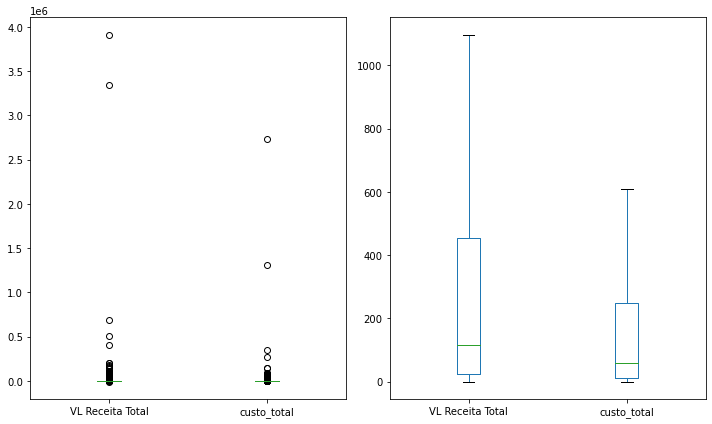

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
ax=base_tratada.boxplot(column=["VL Receita Total","custo_total"],showfliers=False,ax=axes[1])
ax.grid(visible=False)

ax1=base.boxplot(column=["VL Receita Total","custo_total"],showfliers=True, ax=axes[0])
ax1.grid(visible=False)

plt.tight_layout()
plt.show()
#base_tratada.plot(kind='box',figsize=(20,10),subplots=True)

In [16]:
def detect_outliers (df,columns):
    outlier_indices=[]
    for col in columns:
        Q1=np.percentile(df[col],25)
        Q3=np.percentile(df[col],75)
        
        IQR=Q3-Q1
        
        outlier_step=1.5*IQR
        
        outlier_list_col=df[(df[col]<Q1-outlier_step)|(df[col]>Q3+outlier_step)].index
        outlier_indices.extend(outlier_list_col)
        
        
    return (outlier_indices)

In [17]:
#Coloco na variável A1 os índices da tabela que são outliers
A1=detect_outliers(base_tratada,["VL Receita Total","custo_total"])

#filtro a tabela para retirar esses índices
base_tratada_outlier=base_tratada[~base_tratada.index.isin(A1)]

#dados filtrados
base_tratada_outlier.describe().applymap('{:.1f}'.format)

,VL Receita Total,Receita Net MDR,Receita de antecipação de recebiveis,Outras Receitas,Custo de Net MDR,Custo de antecipação de recebiveis,Custo de Outras Receitas,custo_total
count,8342.0,8342.0,8342.0,8342.0,8342.0,8342.0,8342.0,8342.0
mean,175.5,63.1,28.5,78.6,44.2,10.0,39.3,93.5
std,229.0,117.1,103.3,154.0,81.9,36.1,77.0,124.2
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,17.0,0.0,0.0,1.0,0.0,0.0,0.0,8.0
50%,75.0,12.0,0.0,12.0,8.0,0.0,6.0,37.0
75%,237.0,67.0,0.0,74.0,47.0,0.0,37.0,129.0
max,1097.0,862.0,993.0,1096.0,603.0,347.0,548.0,608.0


In [18]:
base_tratada.describe().applymap('{:.1f}'.format)

,VL Receita Total,Receita Net MDR,Receita de antecipação de recebiveis,Outras Receitas,Custo de Net MDR,Custo de antecipação de recebiveis,Custo de Outras Receitas,custo_total
count,9794.0,9794.0,9794.0,9794.0,9794.0,9794.0,9794.0,9794.0
mean,2104.8,813.6,729.5,556.1,569.5,255.3,278.1,1102.9
std,53234.6,39713.0,25283.0,11864.5,27799.1,8849.1,5932.3,31178.3
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,25.0,0.0,0.0,1.0,0.0,0.0,1.0,11.0
50%,115.0,19.0,0.0,19.0,13.0,0.0,9.0,60.0
75%,454.8,128.0,0.0,154.0,90.0,0.0,77.0,250.0
max,3911755.0,3911755.0,2436375.0,899917.0,2738229.0,852731.0,449959.0,2738229.0


In [19]:
#np.percentile(base_tratada["VL Receita Total"],25)
print(base_tratada.shape,base_tratada_outlier.shape)
a=base_tratada.shape[0]-base_tratada_outlier.shape[0]
b=round(a/base_tratada.shape[0]*100,1)
print("diferença de {} linhas. {}% do total".format(a,b))

(9794, 15) (8342, 15)
diferença de 1452 linhas. 14.8% do total


array([[<AxesSubplot:title={'center':'VL Receita Total'}>,
        <AxesSubplot:title={'center':'custo_total'}>]], dtype=object)

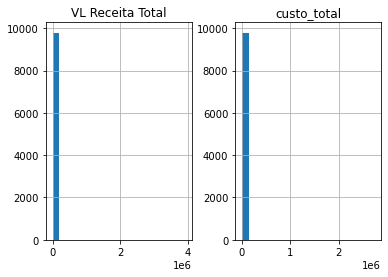

In [20]:
base_tratada[["VL Receita Total","custo_total"]].hist(bins=20)

array([[<AxesSubplot:title={'center':'VL Receita Total'}>,
        <AxesSubplot:title={'center':'custo_total'}>]], dtype=object)

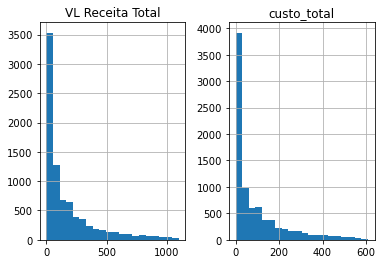

In [21]:
base_tratada_outlier[["VL Receita Total","custo_total"]].hist(bins=20)

In [22]:
#Para finalizar precisamos garantir agora que "VL Receita Total" e´a soma das receitas na vírgula

A2=base_tratada_outlier["VL Receita Total"]==(base_tratada_outlier["Receita Net MDR"]+base_tratada_outlier["Receita de antecipação de recebiveis"]+base_tratada_outlier["Outras Receitas"])
A2.describe()


count     8342
unique       2
top       True
freq      6422
dtype: object

In [23]:
base_tratada_outlier["VL Receita Total"]=base_tratada_outlier["Receita Net MDR"]+base_tratada_outlier["Receita de antecipação de recebiveis"]+base_tratada_outlier["Outras Receitas"]

A3=base_tratada_outlier["VL Receita Total"]==(base_tratada_outlier["Receita Net MDR"]+base_tratada_outlier["Receita de antecipação de recebiveis"]+base_tratada_outlier["Outras Receitas"])
A3.describe()

C:\Users\lucas\AppData\Local\Temp/ipykernel_1784/2156840439.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_tratada_outlier["VL Receita Total"]=base_tratada_outlier["Receita Net MDR"]+base_tratada_outlier["Receita de antecipação de recebiveis"]+base_tratada_outlier["Outras Receitas"]


count     8342
unique       1
top       True
freq      8342
dtype: object

In [24]:
base_tratada_outlier

,Canal,SubCanal,Grupo 1,Grupo 2,Afiliação,VL Receita Total,Receita Net MDR,Receita de antecipação de recebiveis,Outras Receitas,Custo de Net MDR,Custo de antecipação de recebiveis,Custo de Outras Receitas,custo_total,check_receitas,check_custos
0,DIGITAL,SubCanal 1,Grupo B,LIDER FARMER,00254A8E-59B4-40A5-99AC-CA06A1B37663,227,0,0,227,0,0,113,113,False,False
1,DIGITAL,SubCanal 1,Grupo C,JULIO,005e8e74-2412-48d3-b366-fbb8cc3b4e67,206,0,0,206,0,0,103,103,False,False
2,DIGITAL,SubCanal 1,Grupo B,BASE,005F3E61-7757-46F4-A55F-4E2ED5B52835,51,0,0,51,0,0,26,26,False,False
3,DIGITAL,SubCanal 1,Grupo D,INSIDE,006073e9-052c-44e0-aaa9-3f160fb12bb4,206,0,0,206,0,0,103,103,False,False
4,DIGITAL,SubCanal 1,Grupo B,BASE,00F62BB5-45B2-4C41-921B-4E2650FDDBD4,257,0,0,257,0,0,129,129,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10094,DIGITAL,SubCanal 3,Grupo C,ARIELA,5db6fe58321c2c62bde9cded,43,18,0,25,13,0,13,26,False,False
10095,DIGITAL,SubCanal 3,Grupo C,ARIELA,5db6fe75206d7c6832e777bd,160,152,0,8,106,0,4,110,False,False
10096,DIGITAL,SubCanal 3,Grupo C,ARIELA,5db9c3fa82e15f17319b8816,267,52,0,215,37,0,107,144,False,False
10098,DIGITAL,SubCanal 3,Grupo C,ARIELA,5e14711e6204025f8ec3441b,1,0,0,1,0,0,0,0,False,False


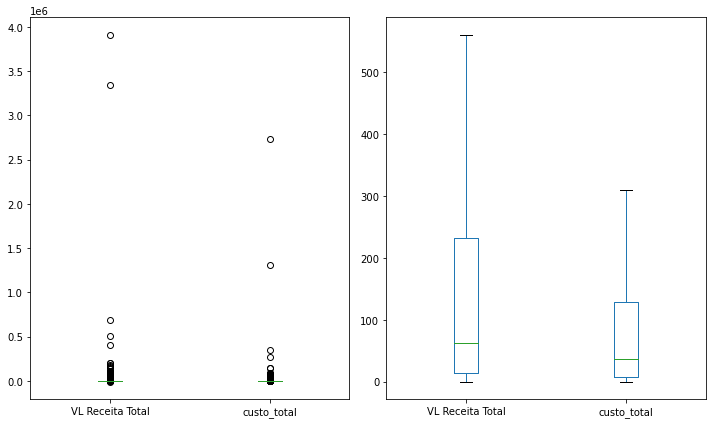

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
ax=base_tratada_outlier.boxplot(column=["VL Receita Total","custo_total"],showfliers=False,ax=axes[1])
ax.grid(visible=False)

ax1=base.boxplot(column=["VL Receita Total","custo_total"],showfliers=True, ax=axes[0])
ax1.grid(visible=False)

plt.tight_layout()
plt.show()
#base_tratada.plot(kind='box',figsize=(20,10),subplots=True)

In [26]:
base_tratada_outlier.describe().applymap('{:.1f}'.format)

,VL Receita Total,Receita Net MDR,Receita de antecipação de recebiveis,Outras Receitas,Custo de Net MDR,Custo de antecipação de recebiveis,Custo de Outras Receitas,custo_total
count,8342.0,8342.0,8342.0,8342.0,8342.0,8342.0,8342.0,8342.0
mean,170.3,63.1,28.5,78.6,44.2,10.0,39.3,93.5
std,230.3,117.1,103.3,154.0,81.9,36.1,77.0,124.2
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,14.0,0.0,0.0,1.0,0.0,0.0,0.0,8.0
50%,63.0,12.0,0.0,12.0,8.0,0.0,6.0,37.0
75%,233.0,67.0,0.0,74.0,47.0,0.0,37.0,129.0
max,1097.0,862.0,993.0,1096.0,603.0,347.0,548.0,608.0


In [27]:
base.describe().applymap('{:.1f}'.format)

,VL Receita Total,Receita Net MDR,Receita de antecipação de recebiveis,Outras Receitas,Custo de Net MDR,Custo de antecipação de recebiveis,Custo de Outras Receitas,custo_total
count,10109.0,10109.0,10109.0,10109.0,10109.0,10109.0,10109.0,10109.0
mean,2114.1,809.3,741.9,557.5,566.5,259.7,278.8,1104.9
std,52457.3,39112.5,24910.8,11822.1,27378.8,8718.8,5911.1,30717.2
min,-7391.0,-7391.0,0.0,-16970.0,-5174.0,0.0,-8485.0,-5174.0
25%,22.0,0.0,0.0,1.0,0.0,0.0,0.0,10.0
50%,111.0,17.0,0.0,18.0,12.0,0.0,9.0,57.0
75%,450.0,123.0,0.0,147.0,86.0,0.0,74.0,245.0
max,3911755.0,3911755.0,2436375.0,899917.0,2738229.0,852731.0,449959.0,2738229.0


## Análise descritiva da base já tratada

Associar as linhas de receita com a carteira em que o cliente se encontra (canal e subcanal) e explique cada uma delas;


In [28]:
base=base_tratada_outlier.copy()
base["lucro Net MDR"]=base["Receita Net MDR"]-base["Custo de Net MDR"]
base["lucro antecipação de recebiveis"]=base["Receita de antecipação de recebiveis"]-base["Custo de antecipação de recebiveis"]
base["lucro outras receitas"]=base["Outras Receitas"]-base["Custo de Outras Receitas"]
base["lucro total"]=base["VL Receita Total"]-base["custo_total"]
base.drop(columns=["check_receitas","check_custos"],inplace=True)

#criação das margens
base["margem Net MDR"]=base["lucro Net MDR"]/base["Receita Net MDR"]
base["margem antecipação de recebiveis"]=base["lucro antecipação de recebiveis"]/base["Receita de antecipação de recebiveis"]
base["margem Outras Receitas"]=base["lucro outras receitas"]/base["Outras Receitas"]
base["margem total"]=base["lucro total"]/base["VL Receita Total"]
base#.fillna(0, inplace=True)

,Canal,SubCanal,Grupo 1,Grupo 2,Afiliação,VL Receita Total,Receita Net MDR,Receita de antecipação de recebiveis,Outras Receitas,Custo de Net MDR,...,Custo de Outras Receitas,custo_total,lucro Net MDR,lucro antecipação de recebiveis,lucro outras receitas,lucro total,margem Net MDR,margem antecipação de recebiveis,margem Outras Receitas,margem total
0,DIGITAL,SubCanal 1,Grupo B,LIDER FARMER,00254A8E-59B4-40A5-99AC-CA06A1B37663,227,0,0,227,0,...,113,113,0,0,114,114,NaN,NaN,0.502203,0.502203
1,DIGITAL,SubCanal 1,Grupo C,JULIO,005e8e74-2412-48d3-b366-fbb8cc3b4e67,206,0,0,206,0,...,103,103,0,0,103,103,NaN,NaN,0.500000,0.500000
2,DIGITAL,SubCanal 1,Grupo B,BASE,005F3E61-7757-46F4-A55F-4E2ED5B52835,51,0,0,51,0,...,26,26,0,0,25,25,NaN,NaN,0.490196,0.490196
3,DIGITAL,SubCanal 1,Grupo D,INSIDE,006073e9-052c-44e0-aaa9-3f160fb12bb4,206,0,0,206,0,...,103,103,0,0,103,103,NaN,NaN,0.500000,0.500000
4,DIGITAL,SubCanal 1,Grupo B,BASE,00F62BB5-45B2-4C41-921B-4E2650FDDBD4,257,0,0,257,0,...,129,129,0,0,128,128,NaN,NaN,0.498054,0.498054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10094,DIGITAL,SubCanal 3,Grupo C,ARIELA,5db6fe58321c2c62bde9cded,43,18,0,25,13,...,13,26,5,0,12,17,0.277778,NaN,0.480000,0.395349
10095,DIGITAL,SubCanal 3,Grupo C,ARIELA,5db6fe75206d7c6832e777bd,160,152,0,8,106,...,4,110,46,0,4,50,0.302632,NaN,0.500000,0.312500
10096,DIGITAL,SubCanal 3,Grupo C,ARIELA,5db9c3fa82e15f17319b8816,267,52,0,215,37,...,107,144,15,0,108,123,0.288462,NaN,0.502326,0.460674
10098,DIGITAL,SubCanal 3,Grupo C,ARIELA,5e14711e6204025f8ec3441b,1,0,0,1,0,...,0,0,0,0,1,1,NaN,NaN,1.000000,1.000000


<module 'matplotlib.pyplot' from 'C:\\Users\\lucas\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

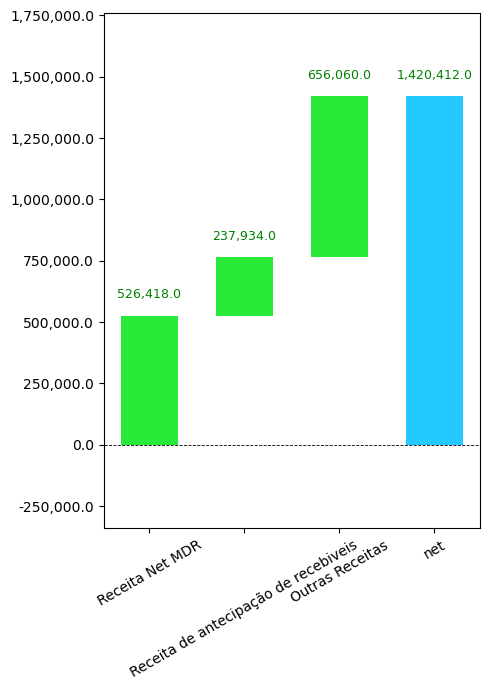

In [29]:
df_=base.groupby("Canal", as_index=False).sum()
df=df_[["Receita Net MDR","Receita de antecipação de recebiveis","Outras Receitas"]].transpose()
df.columns=["Valor"]
plt.rcParams.update({'figure.figsize':(5,7), 'figure.dpi':100})
waterfall_chart.plot(df.index,df.Valor)

C:\Users\lucas\AppData\Local\Temp/ipykernel_1784/223729032.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Custo de Net MDR"]=df["Custo de Net MDR"]*-1
C:\Users\lucas\AppData\Local\Temp/ipykernel_1784/223729032.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Custo de antecipação de recebiveis"]=df["Custo de antecipação de recebiveis"]*-1
C:\Users\lucas\AppData\Local\Temp/ipykernel_1784/223729032.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

<module 'matplotlib.pyplot' from 'C:\\Users\\lucas\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

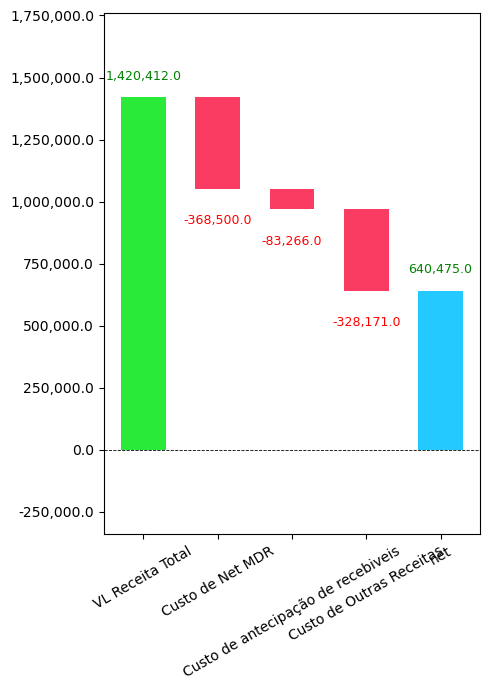

In [30]:
df_=base.groupby("Canal", as_index=False).sum()
df=df_[["VL Receita Total","Custo de Net MDR","Custo de antecipação de recebiveis","Custo de Outras Receitas"]]

df["Custo de Net MDR"]=df["Custo de Net MDR"]*-1
df["Custo de antecipação de recebiveis"]=df["Custo de antecipação de recebiveis"]*-1
df["Custo de Outras Receitas"]=df["Custo de Outras Receitas"]*-1
df=df.transpose()
df.columns=["Valor"]
plt.rcParams.update({'figure.figsize':(5,7), 'figure.dpi':100})
waterfall_chart.plot(df.index,df.Valor)

<AxesSubplot:>

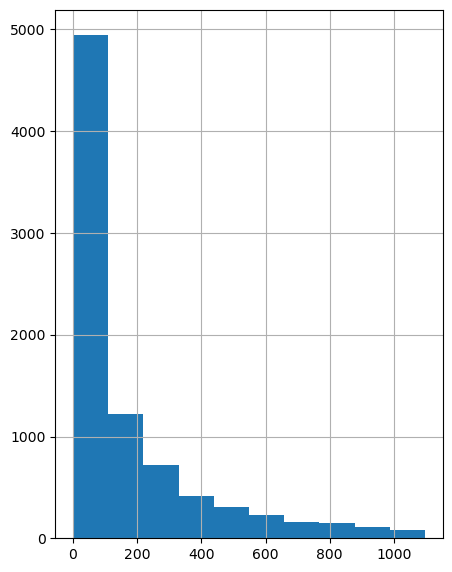

In [31]:
base['VL Receita Total'].hist()


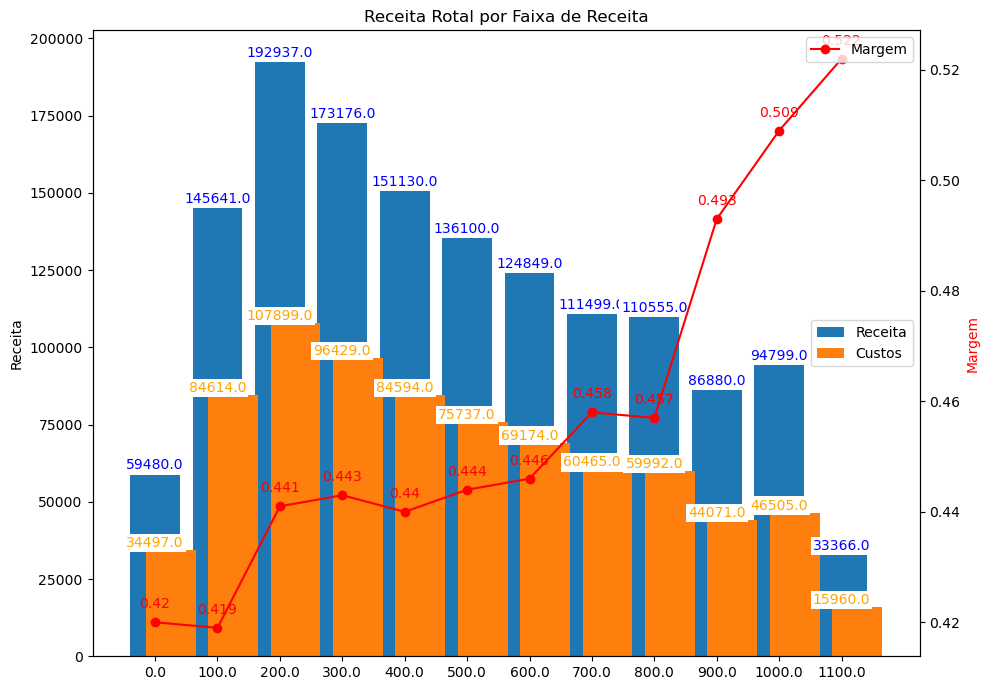

In [32]:
df=base.copy()

df["categoria"]=(round(df["VL Receita Total"]/100,0)*100)
df=df.groupby("categoria",as_index=False).sum().sort_values("categoria",ascending=True)
df["categoria"]=df["categoria"].astype('str')
df["margem_total"]=round(((df["VL Receita Total"]-df['custo_total'])/df["VL Receita Total"]),3)

bar_width = 0.25
index = range(len(df))

fig, ax1 = plt.subplots(figsize=(10, 7))

ax1.bar(df["categoria"], df['VL Receita Total'],label='Receita')
for i, v in enumerate(df['VL Receita Total']):
    ax1.text(i, v + 2, '{:.1f}'.format(v), ha='center',va='bottom',color='blue',bbox=dict(facecolor='white', edgecolor='none', pad=1.5))
ax1.bar([i + bar_width for i in index], df['custo_total'], label='Custos')
for i, v in enumerate(df['custo_total']):
    ax1.text(i, v + 2, '{:.1f}'.format(v), ha='center',va='bottom',color='orange',bbox=dict(facecolor='white', edgecolor='none', pad=1.5))

ax1.set_ylabel("Receita")
ax1.set_title('Receita Rotal por Faixa de Receita')

ax2 = ax1.twinx()
ax2.plot(df["categoria"], df["margem_total"], color='red',marker='o', label='Margem')

for i, j in zip(df["categoria"], df["margem_total"]):
    ax2.annotate(str(j), xy=(i, j), xytext=(0, 10), textcoords='offset points', ha='center', color='red')
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels, loc='upper right')

ax2.set_ylabel('Margem', color='red')
ax1.legend(loc='center right')
fig.tight_layout()
plt.show()

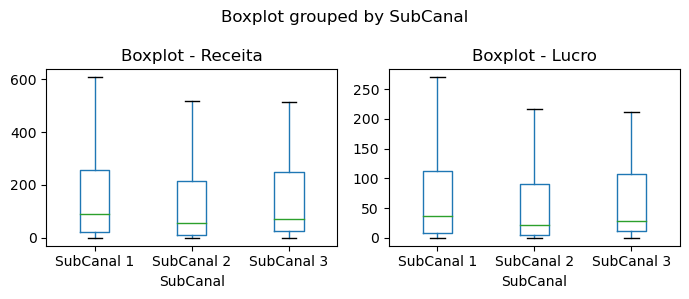

In [33]:
# Fazer o boxplot por categoria da receita e do lucro
fig, axs = plt.subplots(1, 2, figsize=(7, 3))

# Gráfico de Receita
base.boxplot(column='VL Receita Total', by='SubCanal', grid=False, showfliers=False,ax=axs[0])
axs[0].set_title('Boxplot - Receita')

# Gráfico de lucro
base.boxplot(column='lucro total', by='SubCanal', grid=False, showfliers=False,ax=axs[1])
axs[1].set_title('Boxplot - Lucro')

# Ajuste de espaçamento entre os subplots
plt.tight_layout()

# Exibir o gráfico
plt.show()

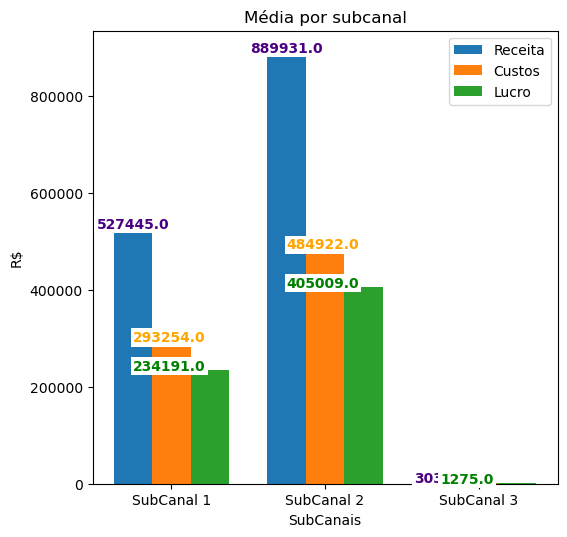

In [34]:
#Como é a média de receita, custos e lucros por SubCanal
dist=0.1
df=base.groupby("SubCanal",as_index=False).sum()
bar_width = 0.25
index = range(len(df))
fig, ax = plt.subplots(figsize=(6, 6))
# Plota as barras para cada coluna
plt.bar(index, df['VL Receita Total'], width=bar_width, label='Receita')
for i, v in enumerate(df['VL Receita Total']):
    plt.text(i, v + dist, '{:.1f}'.format(v), ha='center',color='indigo',fontweight='bold',bbox=dict(facecolor='white', edgecolor='none', pad=1.5))
plt.bar([i + bar_width for i in index], df['custo_total'], width=bar_width, label='Custos')
for i, v in enumerate(df['custo_total']):
    plt.text(i, v + dist, '{:.1f}'.format(v), ha='left',color='orange',fontweight='bold',bbox=dict(facecolor='white', edgecolor='none', pad=1.5))
plt.bar([i + 2 * bar_width for i in index], df['lucro total'], width=bar_width, label='Lucro')
for i, v in enumerate(df['lucro total']):
    plt.text(i, v + dist, '{:.1f}'.format(v), ha='left',color='green',fontweight='bold',bbox=dict(facecolor='white', edgecolor='none', pad=1.5))
# Configurações adicionais do gráfico
plt.xlabel('SubCanais')
plt.ylabel('R$')
plt.title('Média por subcanal')
plt.xticks([i + bar_width for i in index], df['SubCanal'])
plt.legend()

# Exibe o gráfico
plt.show()

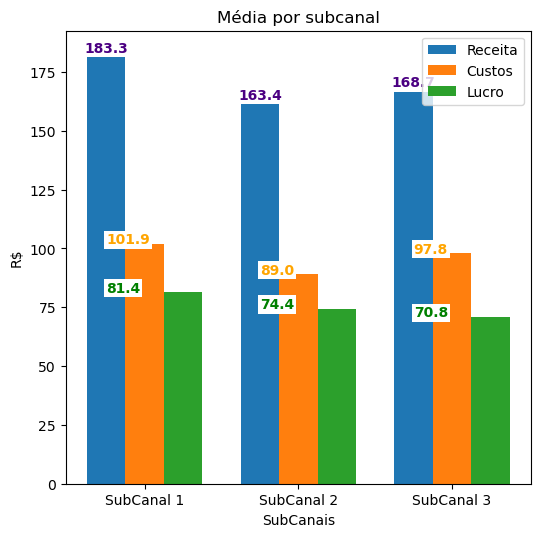

In [35]:
#Como é a média de receita, custos e lucros por SubCanal
dist=0.1
df=base.groupby("SubCanal",as_index=False).mean()
bar_width = 0.25
index = range(len(df))
fig, ax = plt.subplots(figsize=(6, 6))
# Plota as barras para cada coluna
plt.bar(index, df['VL Receita Total'], width=bar_width, label='Receita')
for i, v in enumerate(df['VL Receita Total']):
    plt.text(i, v + dist, '{:.1f}'.format(v), ha='center',color='indigo',fontweight='bold',bbox=dict(facecolor='white', edgecolor='none', pad=1.5))
plt.bar([i + bar_width for i in index], df['custo_total'], width=bar_width, label='Custos')
for i, v in enumerate(df['custo_total']):
    plt.text(i, v + dist, '{:.1f}'.format(v), ha='left',color='orange',fontweight='bold',bbox=dict(facecolor='white', edgecolor='none', pad=1.5))
plt.bar([i + 2 * bar_width for i in index], df['lucro total'], width=bar_width, label='Lucro')
for i, v in enumerate(df['lucro total']):
    plt.text(i, v + dist, '{:.1f}'.format(v), ha='left',color='green',fontweight='bold',bbox=dict(facecolor='white', edgecolor='none', pad=1.5))
# Configurações adicionais do gráfico
plt.xlabel('SubCanais')
plt.ylabel('R$')
plt.title('Média por subcanal')
plt.xticks([i + bar_width for i in index], df['SubCanal'])
plt.legend()

# Exibe o gráfico
plt.show()

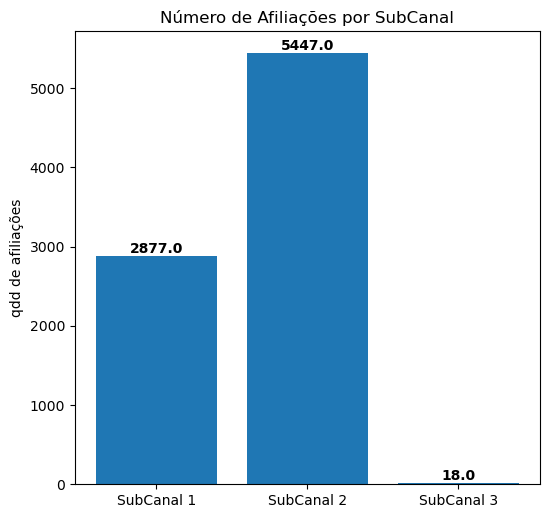

In [36]:
#quantidade de afiliados por subcanal
plt.subplots(figsize=(6, 6))
df=base[["SubCanal","VL Receita Total"]].groupby("SubCanal",as_index=False).count()
plt.bar(df["SubCanal"], df['VL Receita Total'])
for i, v in enumerate(df['VL Receita Total']):
    plt.text(i, v + 1, '{:.1f}'.format(v), ha='center',fontweight='bold',va='bottom')

plt.ylabel("qdd de afiliações")
plt.title('Número de Afiliações por SubCanal')
plt.show()

In [37]:
#Tipo de receita por subcanal
print("Distribuição percentual da Receita por subcanal")
df=base.groupby("SubCanal",as_index=False).sum()[["VL Receita Total","SubCanal","Receita Net MDR","Receita de antecipação de recebiveis","Outras Receitas"]]
df["Receita Net MDR"]=round(df["Receita Net MDR"]/df["VL Receita Total"]*100,2)
df["Receita de antecipação de recebiveis"]=round(df["Receita de antecipação de recebiveis"]/df["VL Receita Total"]*100,2)
df["Outras Receitas"]=round(df["Outras Receitas"]/df["VL Receita Total"]*100,2)
df

Distribuição percentual da Receita por subcanal


,VL Receita Total,SubCanal,Receita Net MDR,Receita de antecipação de recebiveis,Outras Receitas
0,527445,SubCanal 1,36.04,10.77,53.19
1,889931,SubCanal 2,37.66,20.35,41.99
2,3036,SubCanal 3,39.46,0.00,60.54


In [38]:
print("Margem média de cada subcanal")
df2=base.groupby("SubCanal",as_index=False).mean()[["SubCanal","margem Net MDR","margem antecipação de recebiveis","margem Outras Receitas","margem total"]]
df2

Margem média de cada subcanal


,SubCanal,margem Net MDR,margem antecipação de recebiveis,margem Outras Receitas,margem total
0,SubCanal 1,0.297012,0.653819,0.497574,0.425336
1,SubCanal 2,0.298830,0.651542,0.487971,0.433106
2,SubCanal 3,0.250877,NaN,0.531443,0.438468


###### Entendo que:
###### Subcanal 1 é associado com menor RAV e por isso pode representar afiliados com RAV tipo SPOT 
###### Subcanal 2 tem esse processo mais intenso e por isso pode se tratar de afiliados com RAV Automático. 
###### Subcanal 3 é associado com afiliados que nao praticam antecipação. 

In [39]:
#Entendendo como os Grupos são distribuídos dentro dos subcanais

In [40]:
print("GRUPOS POR SUBCANAL")
print("Subcanal 1")
print(base[base["SubCanal"]=="SubCanal 1"]["Grupo 1 "].unique())

print("Subcanal 2")
print(base[base["SubCanal"]=="SubCanal 2"]["Grupo 1 "].unique())

print("Subcanal 3")
print(base[base["SubCanal"]=="SubCanal 3"]["Grupo 1 "].unique())


GRUPOS POR SUBCANAL
Subcanal 1
['Grupo B' 'Grupo C' 'Grupo D' 'Grupo E']
Subcanal 2
['Grupo C' 'Grupo B' 'Grupo E' 'Grupo D' 'Grupo A']
Subcanal 3
['Grupo C' 'Grupo B']


In [41]:
print("Grupos 2 por Subcanal 1")
print(base[base["SubCanal"]=="SubCanal 1"].sort_values("VL Receita Total",ascending=False)["Grupo 2"].unique())

print("Grupos 2 por Subcanal 2")
print(base[base["SubCanal"]=="SubCanal 2"].sort_values("VL Receita Total",ascending=False)["Grupo 2"].unique())

print("Grupos 2 por Subcanal 3")
print(base[base["SubCanal"]=="SubCanal 3"].sort_values("VL Receita Total",ascending=False)["Grupo 2"].unique())

Grupos 2 por Subcanal 1
['INSIDE B' 'BASE' 'FIELD B' 'LARGE A' 'INSIDE A' 'FRED' 'FIELD A'
 'FIELD D' 'FIELD C' 'PARCERIAS' 'PARCERIA GUARDA CHUVA' 'PEDRO' 'INSIDE'
 'LIDER HUNTER' 'LARGE B' 'OYOLA' 'MAX' 'LIDER FARMER' 'LIDER INBOUND'
 'JULIO']
Grupos 2 por Subcanal 2
['BASE' 'VITOR' 'INSIDE B' 'INSIDE A' 'ANDREI' 'LUCCA ZADRA' 'WANESSA'
 'FIELD C' 'ARTHURO' 'RAFAEL' 'BABI' 'LUIS DROGHETTI' 'FELIPA'
 'LIDER HUNTER' 'KAIO' 'AUTOCRED' 'BIA' 'PEDRO2' 'FIELD B' 'JULIA' 'PRI'
 'LIDER FARMER' 'BRUNA' 'FIELD A' 'LIDER INBOUND' 'LARGE A' 'LUKAS'
 'PARCERIAS' 'DEBORA' 'NEIVA' 'DANIEL' 'LIDER HUNTER PG']
Grupos 2 por Subcanal 3
['FARMER A' 'ARIELA']


In [42]:
a=base[base["SubCanal"]=="SubCanal 1"].sort_values("VL Receita Total",ascending=False)["Grupo 2"].unique()
b=base[base["SubCanal"]=="SubCanal 2"].sort_values("VL Receita Total",ascending=False)["Grupo 2"].unique()
c=base[base["SubCanal"]=="SubCanal 3"].sort_values("VL Receita Total",ascending=False)["Grupo 2"].unique()

c1_not_c2=np.setdiff1d(a,b)
c2_not_c1=np.setdiff1d(b,a)
c1_and_c2=np.intersect1d(a,b)
c3=c
array1=["SubCanal 1 - Somente","SubCanal 2 - Somente","SubCanal 2 e 1","SubCanal 3 - Somente"]
array2=[len(c1_not_c2),len(c2_not_c1),len(c1_and_c2),len(c3)]
array3=[
    round(base[base["Grupo 2"].isin(c1_not_c2)]["Afiliação"].count()/len(c1_not_c2),0),
    round(base[base["Grupo 2"].isin(c2_not_c1)]["Afiliação"].count()/len(c2_not_c1),0),
    round(base[base["Grupo 2"].isin(c1_and_c2)]["Afiliação"].count()/len(c1_and_c2),0),
    round(base[base["Grupo 2"].isin(c3)]["Afiliação"].count()/len(c3),0)
]
array4=[
    round(base[base["Grupo 2"].isin(c1_not_c2)]["VL Receita Total"].sum()/len(c1_not_c2),0),
    round(base[base["Grupo 2"].isin(c2_not_c1)]["VL Receita Total"].sum()/len(c2_not_c1),0),
    round(base[base["Grupo 2"].isin(c1_and_c2)]["VL Receita Total"].sum()/len(c1_and_c2),0),
    round(base[base["Grupo 2"].isin(c3)]["VL Receita Total"].sum()/len(c3),0)
]
array5=[
    round(base[base["Grupo 2"].isin(c1_not_c2)]["lucro total"].sum()/len(c1_not_c2),0),
    round(base[base["Grupo 2"].isin(c2_not_c1)]["lucro total"].sum()/len(c2_not_c1),0),
    round(base[base["Grupo 2"].isin(c1_and_c2)]["lucro total"].sum()/len(c1_and_c2),0),
    round(base[base["Grupo 2"].isin(c3)]["lucro total"].sum()/len(c3),0)
]
df_=pd.DataFrame()
df_["Categoria"]=array1
df_["num_vendedores"]=array2
df_["media_afiliações_vendedor"]=array3
df_["media_receita_vendedor"]=array4
df_["media_lucro_vendedor"]=array5
df_["margem_media_vendedor"]=round(df_["media_lucro_vendedor"]/df_["media_receita_vendedor"],2)


df_

,Categoria,num_vendedores,media_afiliações_vendedor,media_receita_vendedor,media_lucro_vendedor,margem_media_vendedor
0,SubCanal 1 - Somente,9,96.0,8613.0,4078.0,0.47
1,SubCanal 2 - Somente,21,59.0,6982.0,3235.0,0.46
2,SubCanal 2 e 1,11,566.0,108475.0,48596.0,0.45
3,SubCanal 3 - Somente,2,9.0,1518.0,638.0,0.42


### Avaliando como cada grupo de vendedores performa individualmente

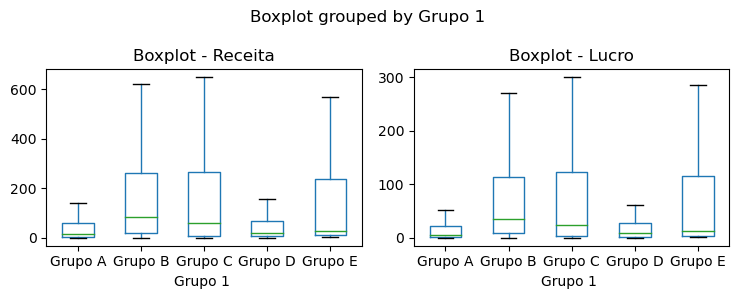

In [43]:
# Fazer o boxplot por categoria da receita e do lucro
fig, axs = plt.subplots(1, 2, figsize=(7.5, 3))

# Gráfico de Receita
base.boxplot(column='VL Receita Total', by='Grupo 1 ', grid=False, showfliers=False,ax=axs[0])
axs[0].set_title('Boxplot - Receita')

# Gráfico de lucro
base.boxplot(column='lucro total', by='Grupo 1 ', grid=False, showfliers=False,ax=axs[1])
axs[1].set_title('Boxplot - Lucro')


# Ajuste de espaçamento entre os subplots
plt.tight_layout()

# Exibir o gráfico
plt.show()

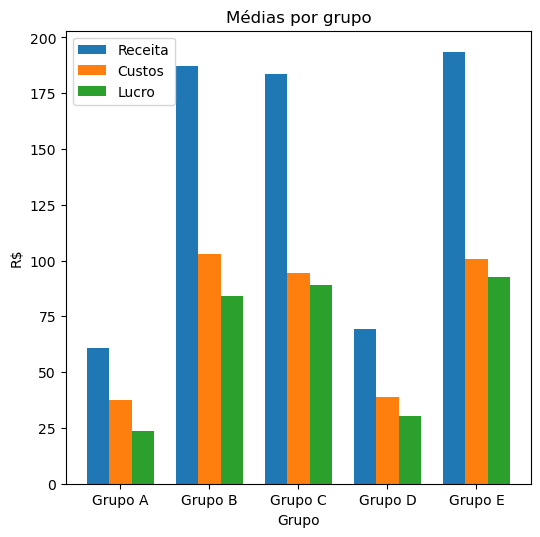

In [44]:
#Como é a média de receita, custos e lucros por Grupo 1 
df=base.groupby("Grupo 1 ",as_index=False).mean()
bar_width = 0.25
index = range(len(df))
fig, ax = plt.subplots(figsize=(6, 6))
# Plota as barras para cada coluna
plt.bar(index, df['VL Receita Total'], width=bar_width, label='Receita')
plt.bar([i + bar_width for i in index], df['custo_total'], width=bar_width, label='Custos')
plt.bar([i + 2 * bar_width for i in index], df['lucro total'], width=bar_width, label='Lucro')

# Configurações adicionais do gráfico
plt.xlabel('Grupo')
plt.ylabel('R$')
plt.title('Médias por grupo')
plt.xticks([i + bar_width for i in index], df['Grupo 1 '])
plt.legend()

# Exibe o gráfico
plt.show()

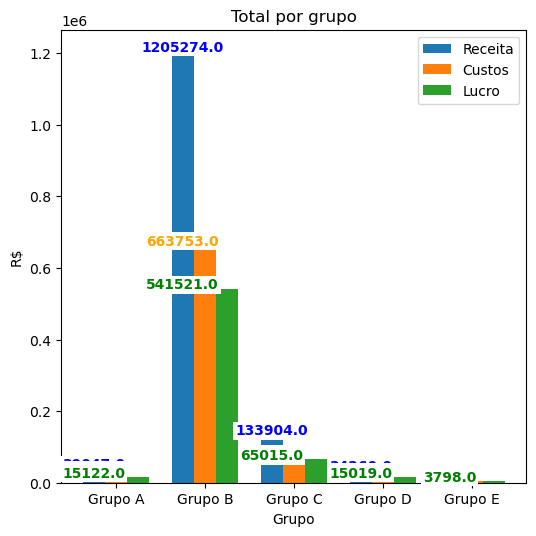

In [45]:
#Como é o total de receita, custos e lucros por SubGrupo
df=base.groupby("Grupo 1 ",as_index=False).sum()
bar_width = 0.25
index = range(len(df))
fig, ax = plt.subplots(figsize=(6, 6))
# Plota as barras para cada coluna
plt.bar(index, df['VL Receita Total'], width=bar_width, label='Receita')
for i, v in enumerate(df['VL Receita Total']):
    plt.text(i, v + dist, '{:.1f}'.format(v), ha='center',color='blue',fontweight='bold',bbox=dict(facecolor='white', edgecolor='none', pad=1.5))
plt.bar([i + bar_width for i in index], df['custo_total'], width=bar_width, label='Custos')
for i, v in enumerate(df['custo_total']):
    plt.text(i, v + dist, '{:.1f}'.format(v), ha='center',color='orange',fontweight='bold',bbox=dict(facecolor='white', edgecolor='none', pad=1.5))
plt.bar([i + 2 * bar_width for i in index], df['lucro total'], width=bar_width, label='Lucro')
for i, v in enumerate(df['lucro total']):
    plt.text(i, v + dist, '{:.1f}'.format(v), ha='center',color='green',fontweight='bold',bbox=dict(facecolor='white', edgecolor='none', pad=1.5))

# Configurações adicionais do gráfico
plt.xlabel('Grupo')
plt.ylabel('R$')
plt.title('Total por grupo')
plt.xticks([i + bar_width for i in index], df['Grupo 1 '])
plt.legend()

# Exibe o gráfico
plt.show()

<Figure size 500x500 with 0 Axes>

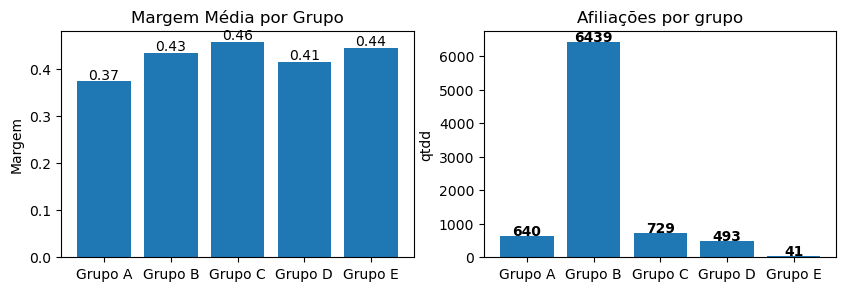

In [46]:
df=base.groupby("Grupo 1 ",as_index=False).mean()
plt.figure(figsize=(5, 5))

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 3))

ax0.bar(df["Grupo 1 "], df['margem total'])
for i, v in enumerate(df['margem total']):
    ax0.text(i, v+0.005, '{:.2f}'.format(v), ha='center')

ax0.set_ylabel('Margem')
ax0.set_title('Margem Média por Grupo')

df_=base.groupby("Grupo 1 ",as_index=False).count()
ax1.bar(df_["Grupo 1 "], df_['VL Receita Total'])
for i, v in enumerate(df_['VL Receita Total']):
    ax1.text(i, v+0.005,str(v), ha='center',fontweight='bold')

ax1.set_ylabel('qtdd')
ax1.set_title('Afiliações por grupo')


plt.show() 


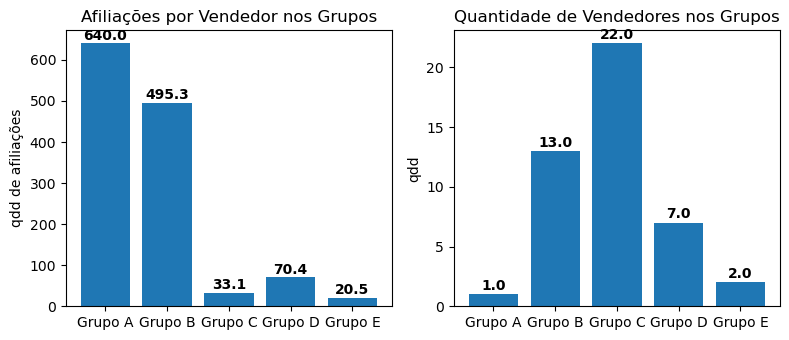

In [47]:
df_=base.groupby("Grupo 1 ",as_index=False).count()
df=base.groupby("Grupo 1 ",as_index=False).nunique()

df_["média de afiliacao por grupo"]=df_['Afiliação']/df["Grupo 2"]

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 3.5))

ax0.bar(df_["Grupo 1 "], df_["média de afiliacao por grupo"])
for i, v in enumerate(df_["média de afiliacao por grupo"]):
    ax0.text(i, v + 1, '{:.1f}'.format(v), ha='center',fontweight='bold',va='bottom')

ax0.set_ylabel("qdd de afiliações")
ax0.set_title('Afiliações por Vendedor nos Grupos')

ax1.bar(df["Grupo 1 "], df["Grupo 2"])
for i, v in enumerate(df["Grupo 2"]):
    ax1.text(i, v + 0.1, '{:.1f}'.format(v), ha='center',fontweight='bold',va='bottom')

ax1.set_ylabel("qdd")
ax1.set_title('Quantidade de Vendedores nos Grupos')

plt.tight_layout()

plt.show()


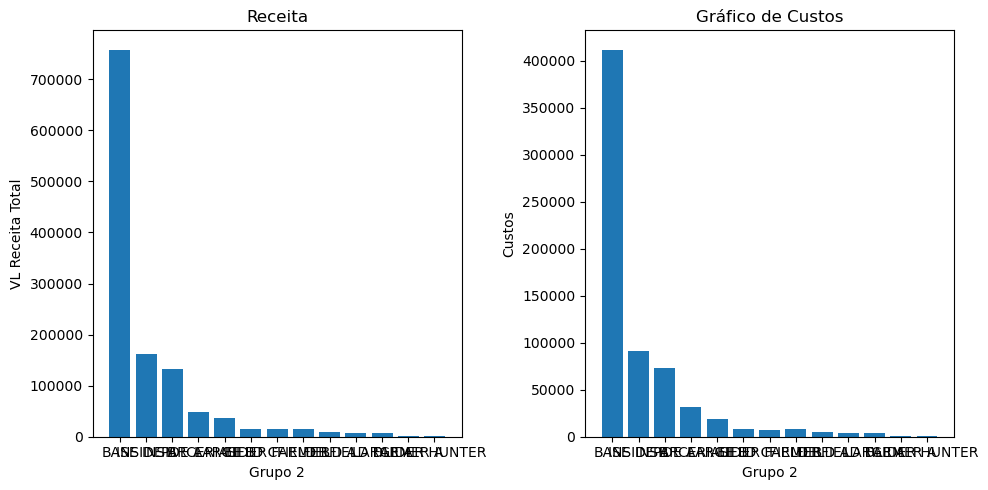

In [48]:
df=base[base["Grupo 1 "]=="Grupo B"].groupby("Grupo 2",as_index=False).sum().sort_values("VL Receita Total",ascending=False)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))

# Gráfico de Receita
ax0.bar(df['Grupo 2'], df['VL Receita Total'])
ax0.set_xlabel('Grupo 2')
ax0.set_ylabel('VL Receita Total')
ax0.set_title('Receita')

# Gráfico de Custos
ax1.bar(df['Grupo 2'], df['custo_total'])
ax1.set_xlabel('Grupo 2')
ax1.set_ylabel('Custos')
ax1.set_title('Gráfico de Custos')


# Ajuste de espaçamento entre os subplots
plt.tight_layout()

# Exibe os gráficos
plt.show()

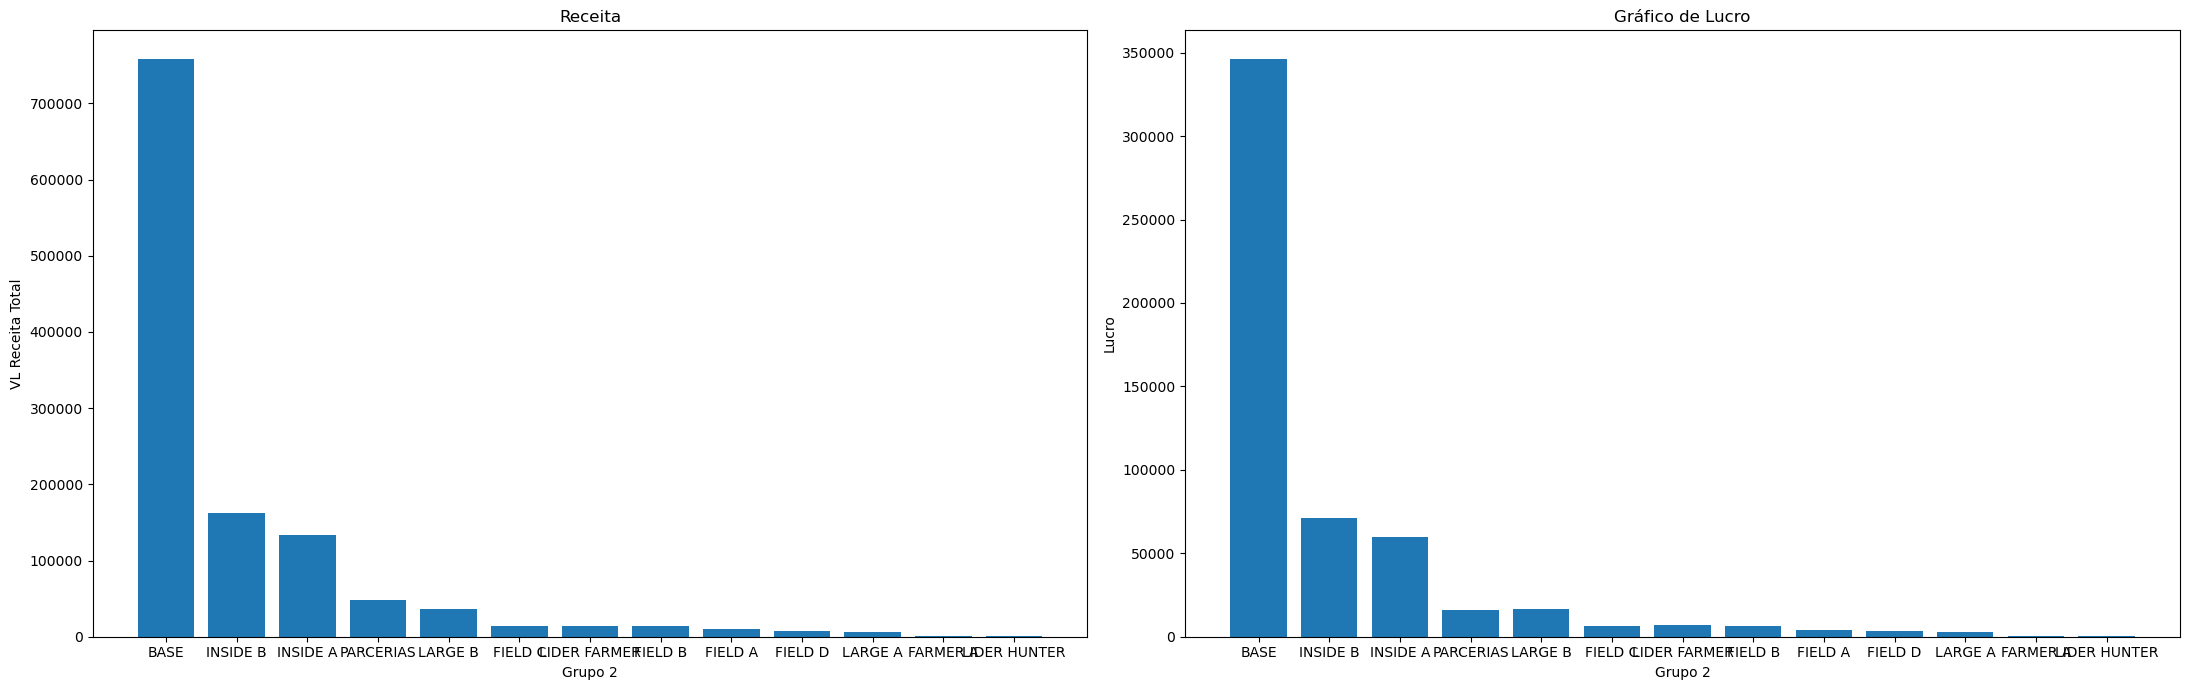

In [49]:
df=base[base["Grupo 1 "]=="Grupo B"].groupby("Grupo 2",as_index=False).sum().sort_values("VL Receita Total",ascending=False)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(22, 7))

# Gráfico de Receita
ax0.bar(df['Grupo 2'], df['VL Receita Total'])
ax0.set_xlabel('Grupo 2')
ax0.set_ylabel('VL Receita Total')
ax0.set_title('Receita')

# Gráfico de Custos
ax1.bar(df['Grupo 2'], df['lucro total'])
ax1.set_xlabel('Grupo 2')
ax1.set_ylabel('Lucro')
ax1.set_title('Gráfico de Lucro')


# Ajuste de espaçamento entre os subplots
plt.tight_layout()

# Exibe os gráficos
plt.show()

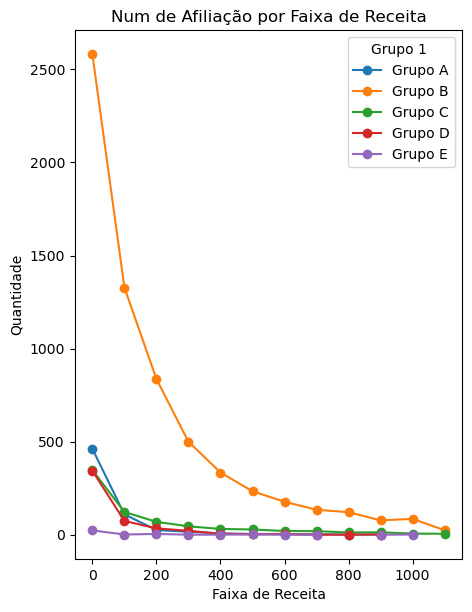

In [50]:
df=base.copy()

df["categoria"]=(round(df["VL Receita Total"]/100,0)*100)
df=df.groupby(["categoria","Grupo 1 "],as_index=False).nunique().sort_values("categoria",ascending=True)
df["categoria"]=df["categoria"]
#df["margem_total"]=round(((df["VL Receita Total"]-df['custo_total'])/df["VL Receita Total"]),3)
df=df[["categoria","Grupo 1 ","Afiliação"]]

df=df.pivot(index='categoria', columns="Grupo 1 ", values='Afiliação').reset_index()
df.set_index('categoria', inplace=True)
df.plot(kind='line', marker='o')
plt.xlabel('Faixa de Receita')
plt.ylabel('Quantidade')
plt.title("Num de Afiliação por Faixa de Receita")
plt.show()


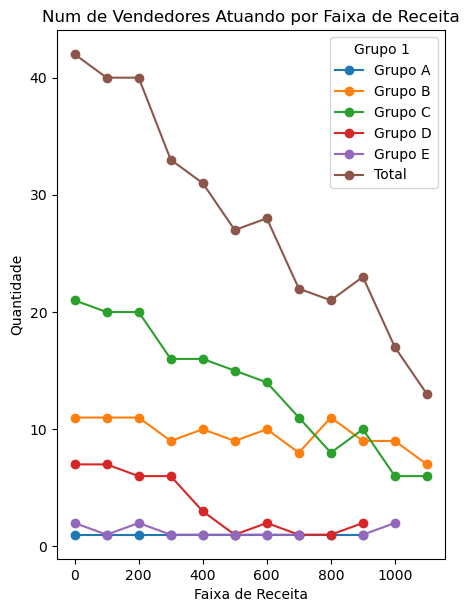

In [51]:
df=base.copy()

df["categoria"]=(round(df["VL Receita Total"]/100,0)*100)
df=df.groupby(["categoria","Grupo 1 "],as_index=False).nunique().sort_values("categoria",ascending=True)
df["categoria"]=df["categoria"]
#df["margem_total"]=round(((df["VL Receita Total"]-df['custo_total'])/df["VL Receita Total"]),3)
df=df[["categoria","Grupo 1 ","Grupo 2"]]

df=df.pivot(index='categoria', columns="Grupo 1 ", values='Grupo 2').reset_index()
df["Total"]=df["Grupo A"].fillna(0)+df["Grupo B"].fillna(0)+df["Grupo C"].fillna(0)+df["Grupo D"].fillna(0)+df["Grupo E"].fillna(0)

df.set_index('categoria', inplace=True)
df.plot(kind='line', marker='o')
plt.xlabel('Faixa de Receita')
plt.ylabel('Quantidade')
plt.title("Num de Vendedores Atuando por Faixa de Receita")
plt.show()

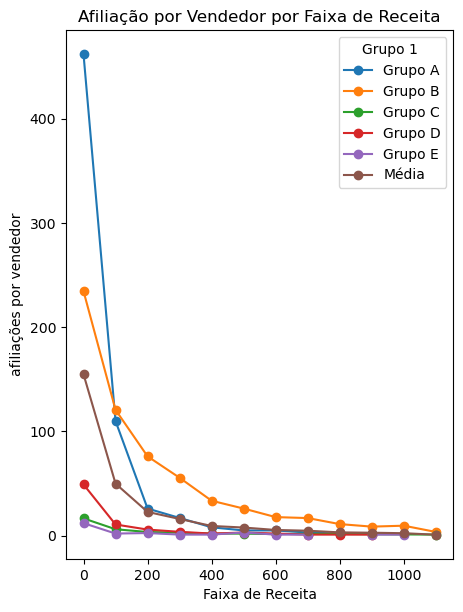

In [52]:
df=base.copy()

df["categoria"]=(round(df["VL Receita Total"]/100,0)*100)
df=df.groupby(["categoria","Grupo 1 "],as_index=False).nunique().sort_values("categoria",ascending=True)
df["categoria"]=df["categoria"]
#df["margem_total"]=round(((df["VL Receita Total"]-df['custo_total'])/df["VL Receita Total"]),3)
df=df[["categoria","Grupo 1 ","Grupo 2","Afiliação"]]
df["Afiliação por vendedor"]=df["Afiliação"]/df["Grupo 2"]
df.drop(columns=["Afiliação","Grupo 2"],inplace=True)

df=df.pivot(index='categoria', columns="Grupo 1 ", values="Afiliação por vendedor").reset_index()
df["Média"]=(df["Grupo A"].fillna(0)+df["Grupo B"].fillna(0)+df["Grupo C"].fillna(0)+df["Grupo D"].fillna(0)+df["Grupo E"].fillna(0))/5

df.set_index('categoria', inplace=True)
df.plot(kind='line', marker='o')
plt.xlabel('Faixa de Receita')
plt.ylabel('afiliações por vendedor')
plt.title("Afiliação por Vendedor por Faixa de Receita")
plt.show()

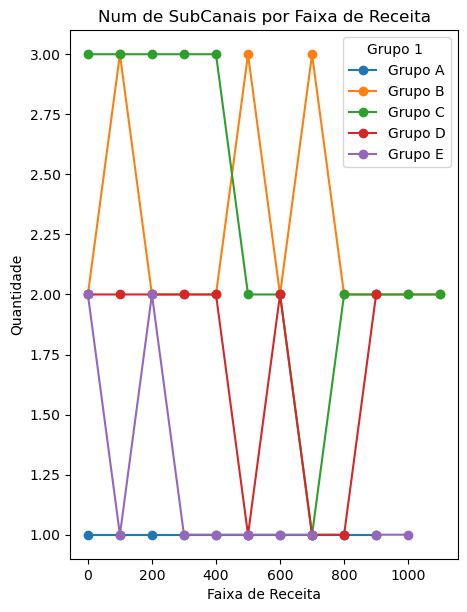

In [53]:
df=base.copy()

df["categoria"]=(round(df["VL Receita Total"]/100,0)*100)
df=df.groupby(["categoria","Grupo 1 "],as_index=False).nunique().sort_values("categoria",ascending=True)
df["categoria"]=df["categoria"]
#df["margem_total"]=round(((df["VL Receita Total"]-df['custo_total'])/df["VL Receita Total"]),3)
df=df[["categoria","Grupo 1 ","SubCanal"]]

df=df.pivot(index='categoria', columns="Grupo 1 ", values="SubCanal").reset_index()
df.set_index('categoria', inplace=True)
df.plot(kind='line', marker='o')
plt.xlabel('Faixa de Receita')
plt.ylabel('Quantidade')
plt.title("Num de SubCanais por Faixa de Receita")
plt.show()

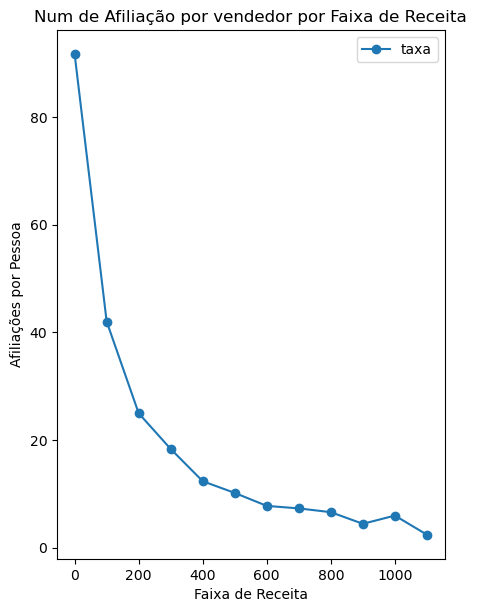

In [54]:
df=base.copy()

df["categoria"]=(round(df["VL Receita Total"]/100,0)*100)
df=df.groupby(["categoria"],as_index=False).nunique().sort_values("categoria",ascending=True)
df["categoria"]=df["categoria"]
#df["margem_total"]=round(((df["VL Receita Total"]-df['custo_total'])/df["VL Receita Total"]),3)
df=df[["categoria","Grupo 2","Afiliação"]]
df["taxa"]=df["Afiliação"]/df["Grupo 2"]
df.drop(columns=["Afiliação","Grupo 2"],inplace=True)

#df=df.pivot(index='categoria', columns="Grupo 2", values='Afiliação').reset_index()
df.set_index('categoria', inplace=True)
df.plot(kind='line', marker='o')
plt.xlabel('Faixa de Receita')
plt.ylabel('Afiliações por Pessoa')
plt.title("Num de Afiliação por vendedor por Faixa de Receita")
plt.show()


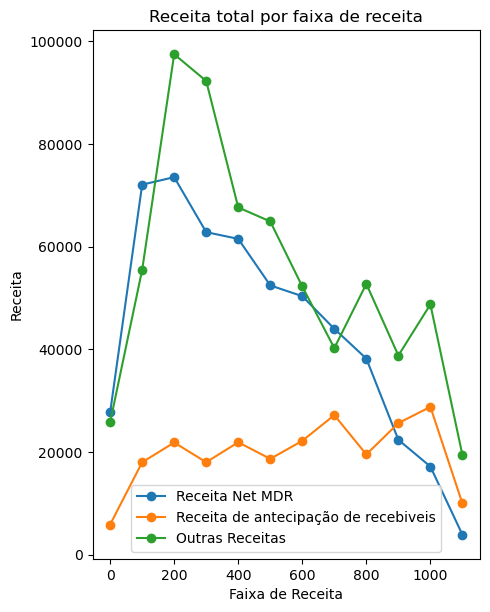

In [55]:
df=base.copy()

df["categoria"]=(round(df["VL Receita Total"]/100,0)*100)
df=df.groupby(["categoria"],as_index=False).sum().sort_values("categoria",ascending=True)
df["categoria"]=df["categoria"]
#df["margem_total"]=round(((df["VL Receita Total"]-df['custo_total'])/df["VL Receita Total"]),3)
df=df[["categoria","Receita Net MDR","Receita de antecipação de recebiveis","Outras Receitas"]]

#df=df.pivot(index='categoria', columns="Grupo 2", values='Afiliação').reset_index()
df.set_index('categoria', inplace=True)
df.plot(kind='line', marker='o')
plt.xlabel('Faixa de Receita')
plt.ylabel('Receita')
plt.title("Receita total por faixa de receita")
plt.show()

In [56]:
df=base.copy()

df["categoria"]=(round(df["VL Receita Total"]/100,0)*100)
df=df.groupby(["categoria"],as_index=False).sum().sort_values("categoria",ascending=True)
df["categoria"]=df["categoria"]
#df["margem_total"]=round(((df["VL Receita Total"]-df['custo_total'])/df["VL Receita Total"]),3)
df=df[["categoria","VL Receita Total","Receita Net MDR","Receita de antecipação de recebiveis","Outras Receitas"]]

df["Receita Net MDR"]=df["Receita Net MDR"]/df["VL Receita Total"]
df["Receita de antecipação de recebiveis"]=df["Receita de antecipação de recebiveis"]/df["VL Receita Total"]
df["Outras Receitas"]=df["Outras Receitas"]/df["VL Receita Total"]
df.drop(columns="VL Receita Total",inplace=True)


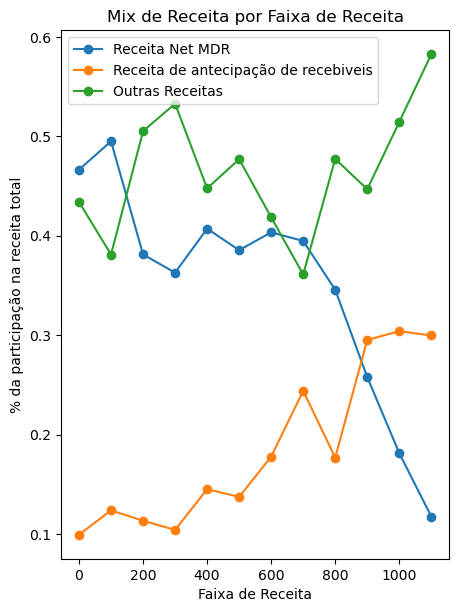

In [57]:
#df=df.pivot(index='categoria', columns="Grupo 2", values='Afiliação').reset_index()
df.set_index('categoria', inplace=True)
df.plot(kind='line', marker='o')
plt.xlabel('Faixa de Receita')
plt.ylabel('% da participação na receita total')
plt.title("Mix de Receita por Faixa de Receita")
plt.show()

In [58]:
base.to_csv("base_tratada.csv")

In [59]:
df=base.copy()

df["categoria"]=(round(df["VL Receita Total"]/100,0)*100)
df=df.groupby(["categoria"],as_index=False).sum().sort_values("categoria",ascending=True)
df["categoria"]=df["categoria"]
#df["margem_total"]=round(((df["VL Receita Total"]-df['custo_total'])/df["VL Receita Total"]),3)
df=df[["categoria","Custo de Net MDR","Custo de antecipação de recebiveis","Custo de Outras Receitas","custo_total"]]

df["Custo de Net MDR"]=df["Custo de Net MDR"]/df["custo_total"]
df["Custo de antecipação de recebiveis"]=df["Custo de antecipação de recebiveis"]/df["custo_total"]
df["Custo de Outras Receitas"]=df["Custo de Outras Receitas"]/df["custo_total"]
df.drop(columns="custo_total",inplace=True)

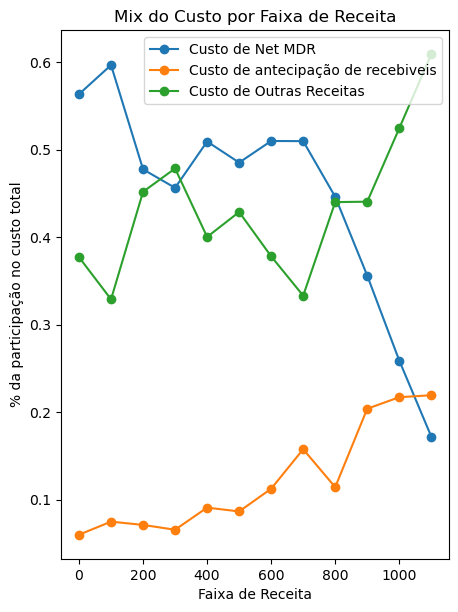

In [60]:
df.set_index('categoria', inplace=True)
df.plot(kind='line', marker='o')
plt.xlabel('Faixa de Receita')
plt.ylabel('% da participação no custo total')
plt.title("Mix do Custo por Faixa de Receita")
plt.show()

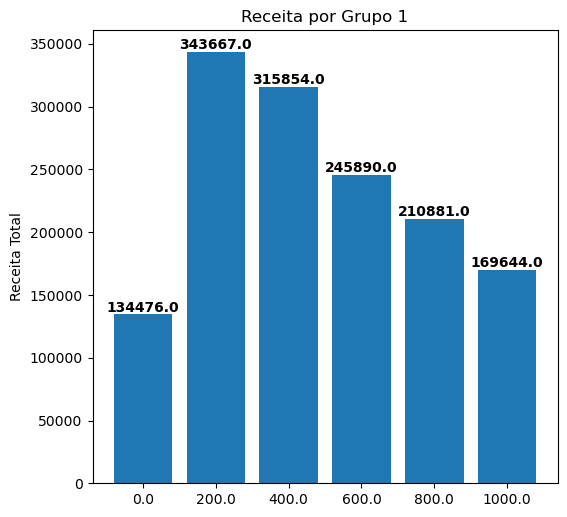

In [61]:
#quantidade de afiliados por subcanal
plt.subplots(figsize=(6, 6))
df=base.copy()
df["categoria"]=(round(df["VL Receita Total"]/200,0)*200)
df=df[["categoria","VL Receita Total"]].groupby("categoria",as_index=False).sum()

plt.bar(df["categoria"].astype('str'), df['VL Receita Total'])
for i, v in enumerate(df['VL Receita Total']):
    plt.text(i, v + 1, '{:.1f}'.format(v), ha='center',fontweight='bold',va='bottom')

plt.ylabel("Receita Total")
plt.title('Receita por Grupo 1')
plt.show()

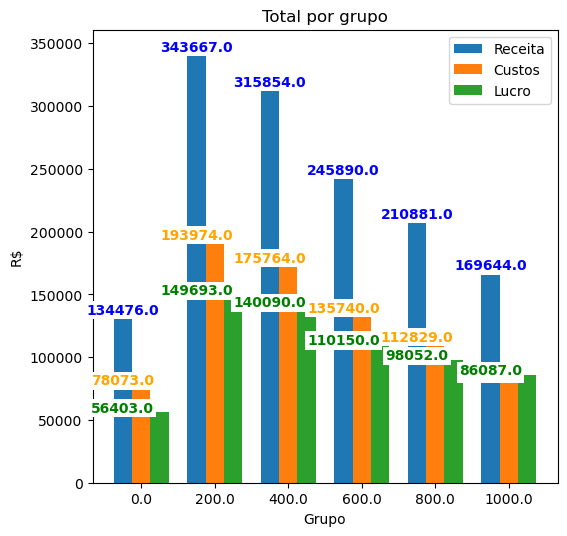

In [62]:
#Como é o total de receita, custos e lucros por SubGrupo
df=base.copy()
df["categoria"]=(round(df["VL Receita Total"]/200,0)*200)
df=df.groupby("categoria",as_index=False).sum()
bar_width = 0.25
index = range(len(df))
fig, ax = plt.subplots(figsize=(6, 6))
# Plota as barras para cada coluna
plt.bar(index, df['VL Receita Total'], width=bar_width, label='Receita')
for i, v in enumerate(df['VL Receita Total']):
    plt.text(i, v + dist, '{:.1f}'.format(v), ha='center',color='blue',fontweight='bold',bbox=dict(facecolor='white', edgecolor='none', pad=1.5))
plt.bar([i + bar_width for i in index], df['custo_total'], width=bar_width, label='Custos')
for i, v in enumerate(df['custo_total']):
    plt.text(i, v + dist, '{:.1f}'.format(v), ha='center',color='orange',fontweight='bold',bbox=dict(facecolor='white', edgecolor='none', pad=1.5))
plt.bar([i + 2 * bar_width for i in index], df['lucro total'], width=bar_width, label='Lucro')
for i, v in enumerate(df['lucro total']):
    plt.text(i, v + dist, '{:.1f}'.format(v), ha='center',color='green',fontweight='bold',bbox=dict(facecolor='white', edgecolor='none', pad=1.5))

# Configurações adicionais do gráfico
plt.xlabel('Grupo')
plt.ylabel('R$')
plt.title('Total por grupo')
plt.xticks([i + bar_width for i in index], df['categoria'].astype('str'))
plt.legend()

# Exibe o gráfico
plt.show()